# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

import warnings
warnings.filterwarnings("ignore")

# Data loading

In [2]:
data_folder = "data"

all_marketing_data = pd.read_csv(f"{data_folder}/marketing_data.csv", parse_dates=["Week"])
all_marketing_data.columns = (
    all_marketing_data.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)
for col in ['expected_spend', 'fact_spend']:
    all_marketing_data[col] = (
        all_marketing_data[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )
all_chat_sessions = pd.read_csv(f"{data_folder}/chat_sessions.csv", parse_dates=["event_time", "user_first_chat"])
all_worktime_schedule = pd.read_csv(f"{data_folder}/worktime_schedule_data.csv", parse_dates=["event_time"])

In [3]:
display(all_marketing_data.head())
display(all_chat_sessions.head())
display(all_worktime_schedule.head())

,week,expected_spend,fact_spend
0,2025-04-28,827050.0,737606.00
1,2025-05-05,896000.0,1144046.49
2,2025-05-12,952000.0,1171861.46
3,2025-05-19,952000.0,1513413.95
4,2025-05-26,892500.0,1291209.25


,session_id,user_id,expert_id,event_time,session_duration,user_first_chat
0,6f157276-25fd-49de-a39e-30a8c6d85430,21221614,1354,2025-01-13 05:19:22,15.333333,2024-10-12 04:59:13
1,9c1479a7-e68e-4ff5-89cc-5eac83a87e25,35973273,1978,2025-01-15 00:30:06,0.983333,2025-01-15 00:30:06
2,52b555fa-73d5-4fe0-881e-691f696ceb6b,35907515,964,2025-01-11 14:03:42,5.016667,2025-01-11 14:03:42
3,ef1c8116-af23-4221-a440-21235e7fda57,35934794,2103,2025-01-13 21:05:40,3.183333,2025-01-13 21:05:40
4,a2a4fa34-1067-4829-91a8-f88e990c1813,36247623,1660,2025-01-19 12:03:02,2.533333,2025-01-19 12:03:02


,event_time,specialist_astrocrm_user_id,online_worktime_duration,busy_worktime_duration,scheduled_duration,force_busy_duration
0,2025-01-11 10:00:00,1102,0.073083,33.937683,0.0,33.937767
1,2025-01-11 10:00:00,1272,26.696617,3.525617,0.0,0.000000
2,2025-01-11 10:00:00,1281,36.005783,0.000000,0.0,0.000000
3,2025-01-11 10:00:00,1478,19.091367,1.182017,0.0,0.000000
4,2025-01-11 10:00:00,1559,35.236700,0.000000,0.0,0.000000


In [4]:
all_chat_sessions.drop_duplicates(subset=["session_id", "user_id", "expert_id"], inplace=True)

In [5]:
data_threshold = all_marketing_data[all_marketing_data['fact_spend'].isna()]['week'].min()

marketing_data_predictive = all_marketing_data[all_marketing_data['week'] >= data_threshold].copy()
marketing_data = all_marketing_data[all_marketing_data['week'] < data_threshold].copy()

chat_sessions_predictive = all_chat_sessions[all_chat_sessions['event_time'] >= data_threshold].copy()
assert chat_sessions_predictive.empty, "Chat sessions found for impossible date."
chat_sessions = all_chat_sessions[all_chat_sessions['event_time'] < data_threshold].copy()

worktime_predictive = all_worktime_schedule[all_worktime_schedule['event_time'] >= data_threshold].copy()
worktime = all_worktime_schedule[all_worktime_schedule['event_time'] < data_threshold].copy()

In [6]:
chat_sessions['hour'] = chat_sessions['event_time'].dt.floor('H')

chat_sessions['time_since_first_chat'] = (chat_sessions['event_time'] - chat_sessions['user_first_chat']).dt.total_seconds()
chat_sessions['returning_user_session'] = chat_sessions['time_since_first_chat'] >= 86400
chat_sessions['new_user_session'] = chat_sessions['time_since_first_chat'] < 86400

demand_df = chat_sessions.groupby('hour').agg(
    chat_sessions=('user_id', 'count'),
    active_users=('user_id', 'nunique'),
    new_user_sessions=('new_user_session', 'sum'),
    returning_user_sessions=('returning_user_session', 'sum'),
    total_session_minutes=('session_duration', 'sum')
).reset_index()

desired_column_order = [
    'hour',
    'active_users',
    'new_user_sessions',
    'returning_user_sessions',
    'chat_sessions',
    'total_session_minutes'
]

demand_df = demand_df[desired_column_order]

demand_df.head()

,hour,active_users,new_user_sessions,returning_user_sessions,chat_sessions,total_session_minutes
0,2025-01-11 09:00:00,195,158,94,252,1323.116667
1,2025-01-11 10:00:00,261,196,181,377,1623.966667
2,2025-01-11 11:00:00,288,230,168,398,2129.866667
3,2025-01-11 12:00:00,325,252,204,456,1957.333333
4,2025-01-11 13:00:00,378,276,248,524,2295.383333


In [7]:
worktime['hour'] = worktime['event_time'].dt.floor('H')

supply_df = worktime.groupby('hour').agg(
    active_experts=('specialist_astrocrm_user_id', 'nunique'),
    scheduled_minutes=('scheduled_duration', 'sum'),
    online_minutes=('online_worktime_duration', 'sum'),
    busy_minutes=('busy_worktime_duration', 'sum'),
    force_busy_minutes=('force_busy_duration', 'sum')
).reset_index()

In [8]:
df_hourly = pd.merge(demand_df, supply_df, on='hour', how='outer').fillna(0)
df_hourly.head()

,hour,active_users,new_user_sessions,returning_user_sessions,chat_sessions,total_session_minutes,active_experts,scheduled_minutes,online_minutes,busy_minutes,force_busy_minutes
0,2025-01-11 09:00:00,195.0,158.0,94.0,252.0,1323.116667,0.0,0.0,0.000000,0.000000,0.000000
1,2025-01-11 10:00:00,261.0,196.0,181.0,377.0,1623.966667,128.0,0.0,1994.482667,1093.446067,513.822650
2,2025-01-11 11:00:00,288.0,230.0,168.0,398.0,2129.866667,203.0,0.0,5291.767200,2551.026483,1126.403633
3,2025-01-11 12:00:00,325.0,252.0,204.0,456.0,1957.333333,233.0,0.0,5899.947250,2539.825633,1255.344100
4,2025-01-11 13:00:00,378.0,276.0,248.0,524.0,2295.383333,224.0,0.0,6332.885517,2646.032817,1195.995150


1. User-to-Expert Ratio

In [9]:
df_hourly['user_to_expert_ratio'] = df_hourly['active_users'] / df_hourly['active_experts'].replace(0, np.nan)

2. Expert Utilization Rate

In [10]:
df_hourly['expert_utilization'] = df_hourly['busy_minutes'] / (df_hourly['online_minutes'] + df_hourly['busy_minutes']).replace(0, np.nan)
df_hourly['expert_utilization'] = df_hourly['expert_utilization']

3. Supply Coverage Rate

In [ ]:
df_hourly['supply_minutes'] = (df_hourly['online_minutes'] + df_hourly['busy_minutes']) - df_hourly['force_busy_minutes']
df_hourly['coverage_rate'] = df_hourly['supply_minutes'] / df_hourly['total_session_minutes'].replace(0, np.nan)

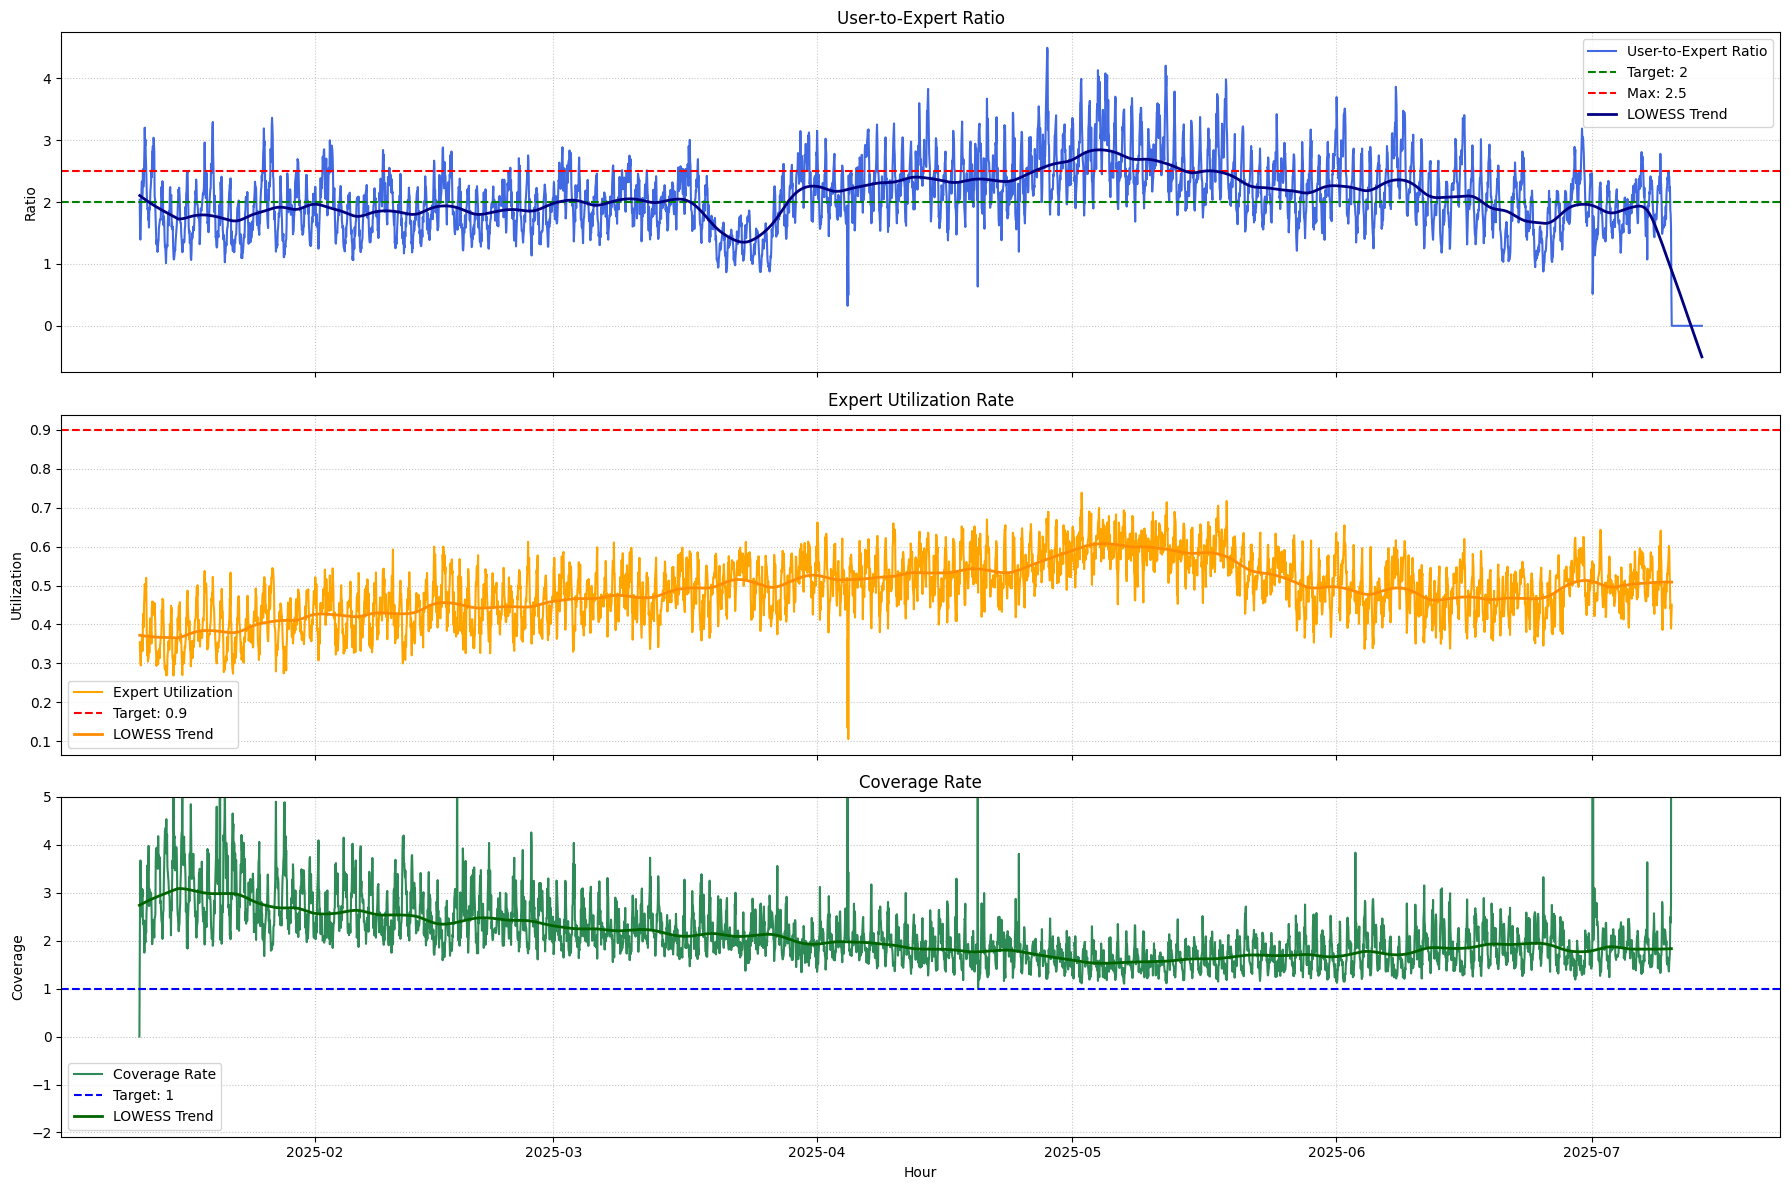

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

def add_trend(ax, x, y, color):
    mask = ~np.isnan(y)
    if mask.sum() > 1:
        x_num = np.array([pd.Timestamp(val).value for val in x[mask]])
        y_num = y[mask]
        smoothed = lowess(y_num, x_num, frac=0.05, return_sorted=True)
        x_smooth = pd.to_datetime(smoothed[:, 0])
        y_smooth = smoothed[:, 1]
        ax.plot(x_smooth, y_smooth, color=color, linestyle='-', linewidth=2, label='LOWESS Trend')

# User-to-Expert Ratio
sns.lineplot(ax=axs[0], x=df_hourly['hour'], y=df_hourly['user_to_expert_ratio'], color='royalblue', label='User-to-Expert Ratio')
axs[0].axhline(2, color='green', linestyle='--', label='Target: 2')
axs[0].axhline(2.5, color='red', linestyle='--', label='Max: 2.5')
add_trend(axs[0], df_hourly['hour'], df_hourly['user_to_expert_ratio'].values, 'navy')
axs[0].set_ylabel('Ratio')
axs[0].set_title('User-to-Expert Ratio')
axs[0].legend()
axs[0].grid(True, linestyle=':', alpha=0.7)

# Expert Utilization Rate
sns.lineplot(ax=axs[1], x=df_hourly['hour'], y=df_hourly['expert_utilization'], color='orange', label='Expert Utilization')
axs[1].axhline(0.9, color='red', linestyle='--', label='Target: 0.9')
add_trend(axs[1], df_hourly['hour'], df_hourly['expert_utilization'].values, 'darkorange')
axs[1].set_ylabel('Utilization')
axs[1].set_title('Expert Utilization Rate')
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.7)

# Coverage Rate
sns.lineplot(ax=axs[2], x=df_hourly['hour'], y=df_hourly['coverage_rate'], color='seagreen', label='Coverage Rate')
axs[2].axhline(1, color='blue', linestyle='--', label='Target: 1')
add_trend(axs[2], df_hourly['hour'], df_hourly['coverage_rate'].values, 'darkgreen')
axs[2].set_ylabel('Coverage')
axs[2].set_title('Coverage Rate')
axs[2].set_ylim(top=5)
axs[2].legend()
axs[2].grid(True, linestyle=':', alpha=0.7)

plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# Predicting demand

* In **users**:
    $$
    \text{Demand}_t = \text{NewUsers}_t + \text{ReturningUsers}_t
    $$
    * $\text{NewUsers}_t$: Users, that visited our platform for the first time;
    * $\text{ReturningUsers}_t$: Users, that have returned to our platform after 24h+ break;

* In **sessions**:
    $$
    \text{Demand}_t = \text{NewUsersSessions}_t + \text{ReturningUsersSessions}_t
    $$
    * $\text{NewUsersSessions}_t$: Sessions, of users that visited our platform for the first time in recent 24 hours;
    * $\text{ReturningUsersSessions}_t$: Sessions of users, that have returned to our platform after 24h+ break;
* In **minutes**:
    $$
    \text{Demand}_t = \text{NewUsersSessionsTime}_t + \text{ReturningUsersSessionsTime}_t
    $$
    * $\text{NewUsersSessionsTime}_t$: Total duration of sessions, of users that visited our platform for the first time in recent 24 hours;
    * $\text{ReturningUsersSessionsTime}_t$: Total duration of sessions of users, that have returned to our platform after 24h+ break;

**However**, we are given an optimal ratio of users to experts is 2, so for predicting I will focus on that. 

## New users prediction

In [13]:
chat_sessions['week'] = chat_sessions['user_first_chat'].dt.to_period('W').dt.start_time

new_users_weekly = chat_sessions.drop_duplicates('user_id').groupby('week').size().reset_index(name='new_users')

df_spend = marketing_data.copy()
df_spend['week'] = pd.to_datetime(df_spend['week'])

last_week = new_users_weekly['week'].max()
new_users_weekly = new_users_weekly[new_users_weekly['week'] < last_week]
df_spend = df_spend[df_spend['week'] < last_week]

df_model = pd.merge(df_spend, new_users_weekly, on='week', how='left').fillna(0)

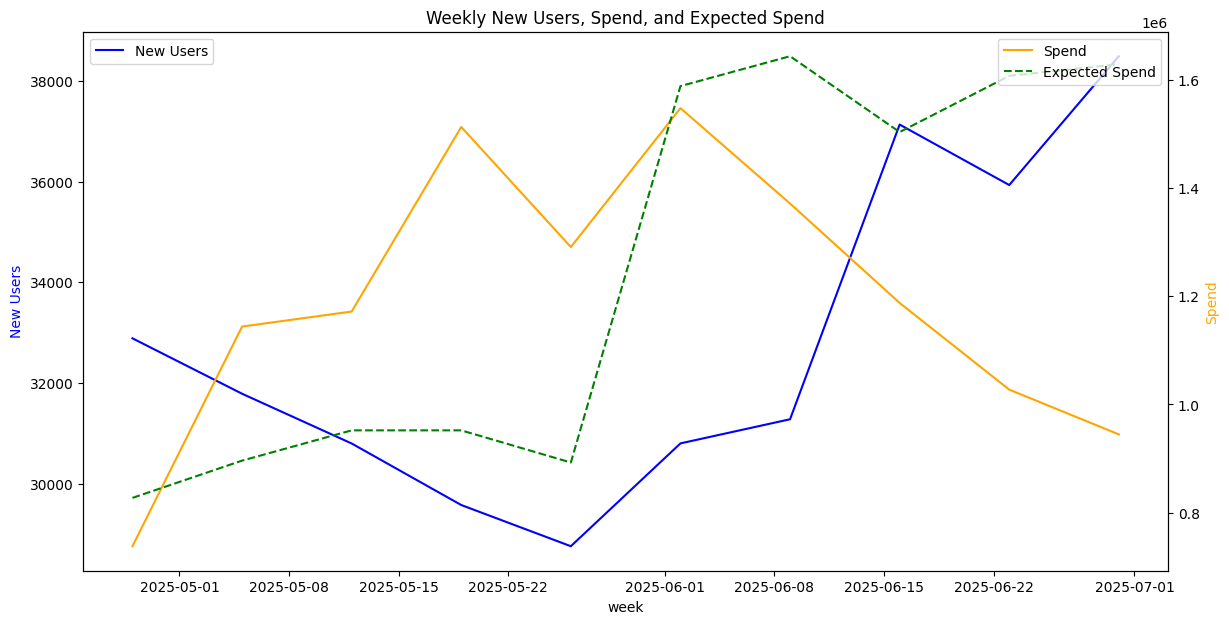

In [14]:
# Plot new users, spend, and expected spend
fig, ax1 = plt.subplots(figsize=(14, 7))
sns.lineplot(ax=ax1, x=df_model['week'], y=df_model['new_users'], color='blue', label='New Users')
ax1.set_ylabel('New Users', color='blue')
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, x=df_model['week'], y=df_model['fact_spend'], color='orange', label='Spend')
sns.lineplot(ax=ax2, x=df_model['week'], y=df_model['expected_spend'], color='green', label='Expected Spend', linestyle='--')
ax2.set_ylabel('Spend', color='orange')
ax1.set_title('Weekly New Users, Spend, and Expected Spend')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [15]:
df_reg = df_model.copy()
df_reg['fact_spend_log'] = np.log1p(df_reg['fact_spend'])
df_reg['fact_spend_log_sq'] = df_reg['fact_spend_log'] ** 2
df_reg['fact_spend_log_lag1'] = df_reg['fact_spend_log'].shift(1)
df_reg['fact_spend_log_lag1_sq'] = df_reg['fact_spend_log_lag1'] ** 2
df_reg['new_users_log'] = np.log1p(df_reg['new_users'])

df_reg = df_reg.dropna().reset_index(drop=True)

user_model = smf.ols(
    formula="new_users_log ~ fact_spend_log + fact_spend_log_sq",
    data=df_reg
).fit()

print(user_model.summary())

                            OLS Regression Results                            
Dep. Variable:          new_users_log   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     5.386
Date:                Sat, 26 Jul 2025   Prob (F-statistic):             0.0458
Time:                        16:18:18   Log-Likelihood:                 12.682
No. Observations:                   9   AIC:                            -19.36
Df Residuals:                       6   BIC:                            -18.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           234.3744    195.59

In [16]:
future = marketing_data_predictive.copy().drop(columns={'fact_spend'})
future = future.rename(columns={'expected_spend': 'fact_spend'})
future['fact_spend_log'] = np.log1p(future['fact_spend'])
future['fact_spend_log_sq'] = future['fact_spend_log'] ** 2

pred_results = user_model.get_prediction(future)
pred_summary = pred_results.summary_frame(alpha=0.05)  # 95% CI

future.reset_index(drop=True, inplace=True)

future['new_users_log_pred'] = pred_summary['mean']
future['predicted_new_users'] = np.expm1(pred_summary['mean'])
future['predicted_new_users_lower'] = np.expm1(pred_summary['mean_ci_lower'])
future['predicted_new_users_upper'] = np.expm1(pred_summary['mean_ci_upper'])

display(future[['week', 'fact_spend', 'predicted_new_users', 'predicted_new_users_lower', 'predicted_new_users_upper']])
predicted_new_users = future[['week', 'fact_spend', 'predicted_new_users_upper']].copy()
predicted_new_users['predicted_new_users'] = predicted_new_users['predicted_new_users_upper'].round().astype(int)
predicted_new_users.drop(columns='predicted_new_users_upper', inplace=True)


,week,fact_spend,predicted_new_users,predicted_new_users_lower,predicted_new_users_upper
0,2025-07-14,1687700.0,30554.292488,24197.958901,38580.242393
1,2025-07-21,1691200.0,30569.319755,24135.572558,38718.020594
2,2025-07-28,1698200.0,30600.170394,24010.587435,38998.155387
3,2025-08-04,1732164.0,30764.631594,23401.336368,40444.709031
4,2025-08-11,1766807.0,30956.819218,22778.071101,42072.119068
5,2025-08-18,1802143.0,31177.243264,22143.905148,43895.455937
6,2025-08-25,1838186.0,31426.490060,21501.544130,45932.500963
7,2025-09-01,1874950.0,31705.223855,20853.382759,48203.957335
8,2025-09-08,1912449.0,32014.188817,20201.573264,50733.740650
9,2025-09-15,1950698.0,32354.220630,19548.056469,53549.426012


## Estimating sessions per new user

In [17]:
new_user_session_counts = chat_sessions[chat_sessions['new_user_session']].groupby('user_id').size()

avg_sessions_per_new_user = new_user_session_counts.mean()
print(f"Mean sessions per new user: {avg_sessions_per_new_user:.2f}")

Mean sessions per new user: 1.43


In [18]:
window_size = 3

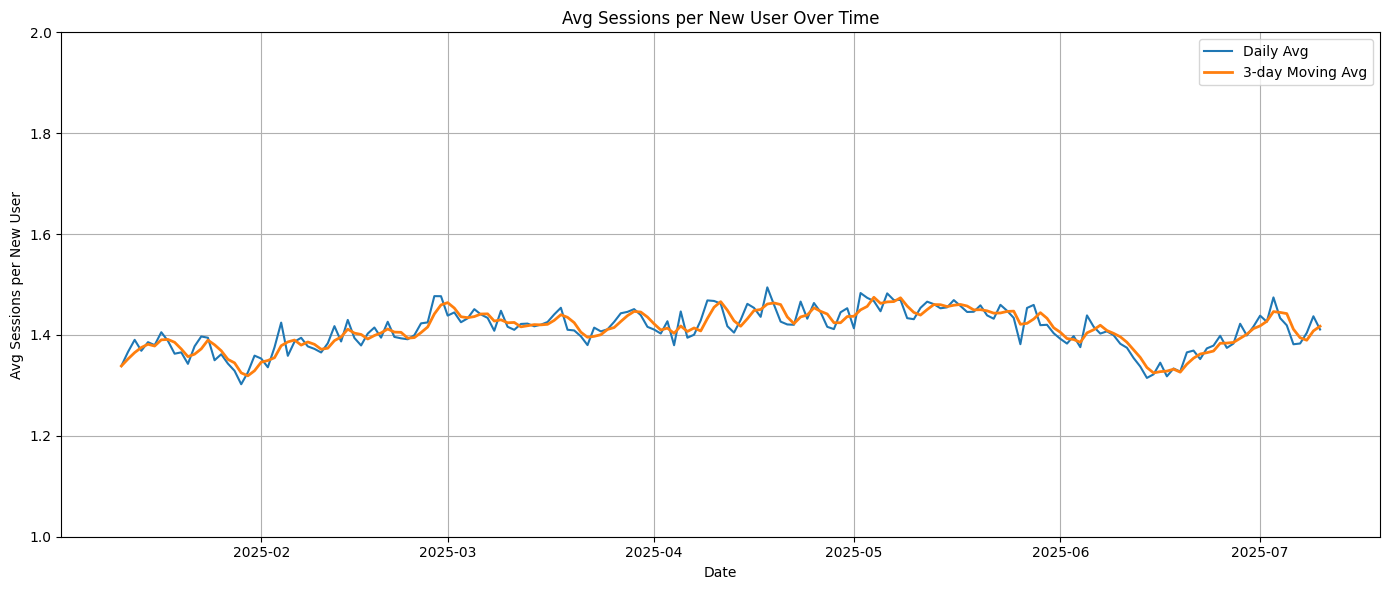

In [19]:
new_user_sessions = chat_sessions[chat_sessions['new_user_session']].copy()
new_user_sessions['event_time'] = new_user_sessions['event_time'].dt.date

daily_new_user_stats = (
    new_user_sessions.groupby('event_time')
    .agg(
        total_sessions=('user_id', 'count'),
        unique_new_users=('user_id', 'nunique')
    )
)
daily_new_user_stats['avg_sessions_per_new_user'] = (
    daily_new_user_stats['total_sessions'] / daily_new_user_stats['unique_new_users']
)

daily_new_user_stats['moving_avg'] = (
    daily_new_user_stats['avg_sessions_per_new_user'].rolling(window=window_size, min_periods=1).mean()
)

plt.figure(figsize=(14, 6))
plt.plot(daily_new_user_stats.index, daily_new_user_stats['avg_sessions_per_new_user'], label='Daily Avg')
plt.plot(daily_new_user_stats.index, daily_new_user_stats['moving_avg'], label=f'{window_size}-day Moving Avg', linewidth=2)
plt.title('Avg Sessions per New User Over Time')
plt.xlabel('Date')
plt.ylabel('Avg Sessions per New User')
plt.ylim(1, 2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
predicted_new_users['new_users_sessions'] = (predicted_new_users['predicted_new_users'] * avg_sessions_per_new_user
                                             ).round().astype(int)
display(predicted_new_users)

,week,fact_spend,predicted_new_users,new_users_sessions
0,2025-07-14,1687700.0,38580,55217
1,2025-07-21,1691200.0,38718,55414
2,2025-07-28,1698200.0,38998,55815
3,2025-08-04,1732164.0,40445,57886
4,2025-08-11,1766807.0,42072,60215
5,2025-08-18,1802143.0,43895,62824
6,2025-08-25,1838186.0,45933,65741
7,2025-09-01,1874950.0,48204,68991
8,2025-09-08,1912449.0,50734,72612
9,2025-09-15,1950698.0,53549,76641


*Additionaly*, for checking some other metrics, let's also predict minutes:

In [21]:
avg_session_duration_new_user = new_user_sessions['session_duration'].mean()
print(f"Mean session duration for new user: {avg_session_duration_new_user:.2f} minutes")

Mean session duration for new user: 3.72 minutes


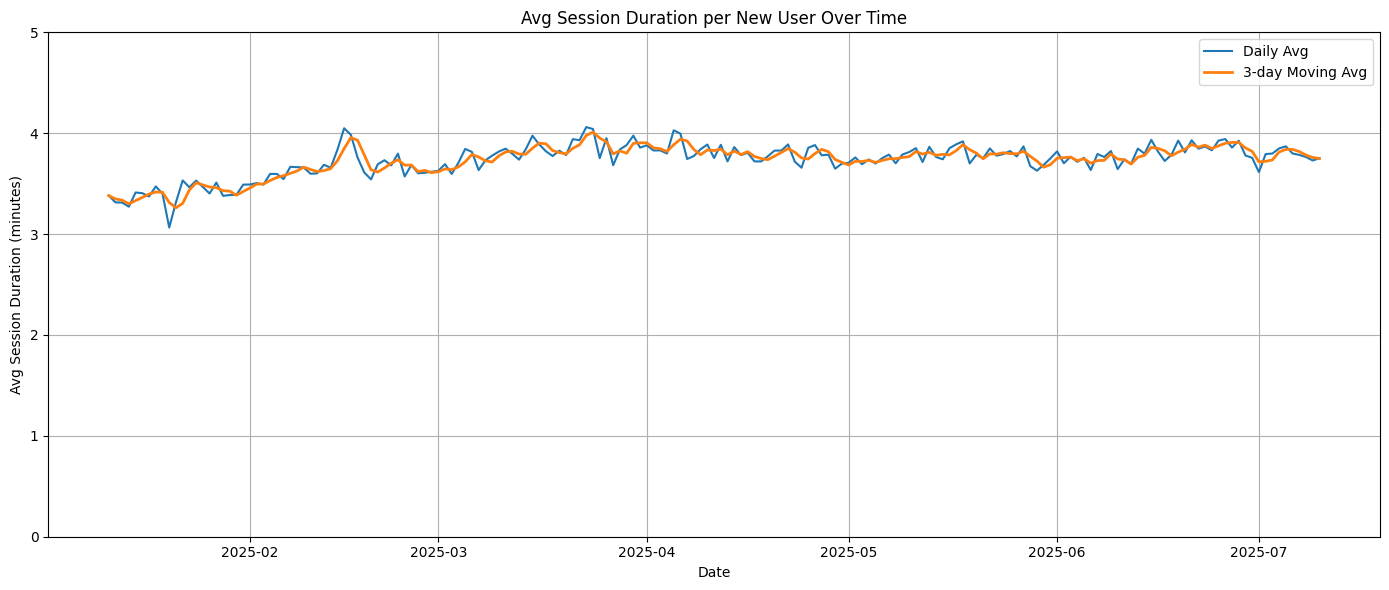

In [22]:
new_user_sessions['event_time'] = pd.to_datetime(new_user_sessions['event_time']).dt.date

daily_session_duration = (
    new_user_sessions.groupby('event_time')
    .agg(
        avg_session_duration=('session_duration', 'mean')
    )
)

daily_session_duration['moving_avg'] = (
    daily_session_duration['avg_session_duration'].rolling(window=window_size, min_periods=1).mean()
)

plt.figure(figsize=(14, 6))
plt.plot(daily_session_duration.index, daily_session_duration['avg_session_duration'], label='Daily Avg')
plt.plot(daily_session_duration.index, daily_session_duration['moving_avg'], label=f'{window_size}-day Moving Avg', linewidth=2)
plt.title('Avg Session Duration per New User Over Time')
plt.xlabel('Date')
plt.ylabel('Avg Session Duration (minutes)')
plt.ylim(0, 5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
predicted_new_users['new_sessions_minutes'] = predicted_new_users['new_users_sessions'] * avg_session_duration_new_user
display(predicted_new_users)

,week,fact_spend,predicted_new_users,new_users_sessions,new_sessions_minutes
0,2025-07-14,1687700.0,38580,55217,205628.926082
1,2025-07-21,1691200.0,38718,55414,206362.557000
2,2025-07-28,1698200.0,38998,55815,207855.886941
3,2025-08-04,1732164.0,40445,57886,215568.321625
4,2025-08-11,1766807.0,42072,60215,224241.552131
5,2025-08-18,1802143.0,43895,62824,233957.506785
6,2025-08-25,1838186.0,45933,65741,244820.458003
7,2025-09-01,1874950.0,48204,68991,256923.506154
8,2025-09-08,1912449.0,50734,72612,270408.163802
9,2025-09-15,1950698.0,53549,76641,285412.219494


## Returning users prediction

In [24]:
first_sessions = chat_sessions.groupby('user_id')['event_time'].min().reset_index()
first_sessions.rename(columns={'event_time': 'first_session_time'}, inplace=True)

full_df = chat_sessions.copy()
full_df['user_signup_week'] = full_df['user_first_chat'].dt.to_period('W').dt.start_time
full_df['session_week'] = full_df['event_time'].dt.to_period('W').dt.start_time
full_df['week_index'] = (full_df['session_week'] - full_df['user_signup_week']).dt.days // 7

full_df = full_df.merge(first_sessions, on='user_id', how='inner')
full_df = full_df[full_df['user_first_chat'] == full_df['first_session_time']]

full_df = full_df.drop(columns=['first_session_time'])

df = full_df[['user_id', 'user_signup_week', 'session_week', 'week_index']].drop_duplicates()
df.head()

,user_id,user_signup_week,session_week,week_index
1,35973273,2025-01-13,2025-01-13,0
4,35907515,2025-01-06,2025-01-06,0
10,35934794,2025-01-13,2025-01-13,0
11,36247623,2025-01-13,2025-01-13,0
203,36253515,2025-01-13,2025-01-13,0


In [25]:
user_week_activity = df[['user_id', 'user_signup_week', 'week_index']].drop_duplicates()
user_week_activity['active'] = 1

cohort_sizes = user_week_activity[['user_id', 'user_signup_week']].drop_duplicates()
cohort_sizes = cohort_sizes.groupby('user_signup_week').size().rename('cohort_size')

retention_counts = (
    user_week_activity
    .groupby(['user_signup_week', 'week_index'])['user_id']
    .nunique()
    .unstack(fill_value=0)
)

retention = retention_counts.div(cohort_sizes, axis=0).reset_index()

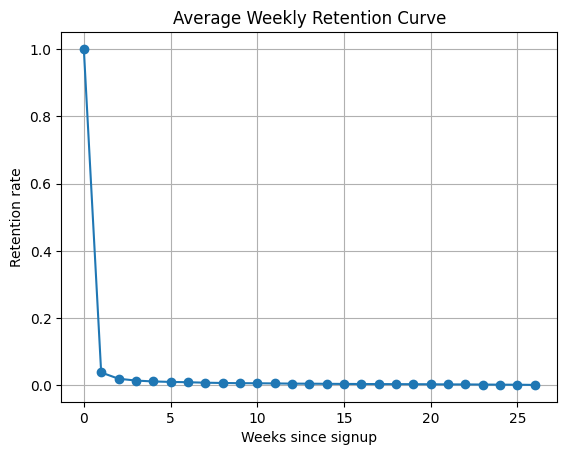

In [26]:
# avg_retention_curve = retention.drop(columns='user_signup_week').mean()
avg_retention_curve = retention.drop(columns='user_signup_week').replace(0, np.nan).mean(skipna=True)
avg_retention_curve.plot(marker='o', title='Average Weekly Retention Curve')
plt.xlabel('Weeks since signup')
plt.ylabel('Retention rate')
plt.grid(True)
plt.show()

In [27]:
def compute_returning_users(historical, forecast_df, retention_curve):
    historical = historical.copy()
    forecast_df = forecast_df.copy()
    historical['week'] = pd.to_datetime(historical['week'])
    forecast_df['week'] = pd.to_datetime(forecast_df['week'])

    # Add column to match structure
    historical = historical.rename(columns={'new_users': 'predicted_new_users'})
    historical['source'] = 'historical'
    forecast_df['source'] = 'forecast'

    # Combine both
    cohorts = pd.concat([historical, forecast_df], ignore_index=True)
    cohorts = cohorts.sort_values('week').reset_index(drop=True)

    # Map from week to new users
    week_to_new_users = dict(zip(cohorts['week'], cohorts['predicted_new_users']))

    # Create empty column for returning_users
    forecast_df['returning_users'] = 0.0

    # Loop over each forecast week
    for i, forecast_row in forecast_df.iterrows():
        target_week = forecast_row['week']
        returning_total = 0.0

        # Loop over all previous cohorts
        for cohort_week, cohort_users in week_to_new_users.items():
            if cohort_week >= target_week:
                continue
            week_offset = (target_week - cohort_week).days // 7
            retention = retention_curve.get(week_offset, 0.0)
            returning_total += cohort_users * retention

        forecast_df.at[i, 'returning_users'] = returning_total

    forecast_df['returning_users'] = forecast_df['returning_users'].round().astype(int)
    return forecast_df.drop(columns=['source'])

In [28]:
predicted_users = compute_returning_users(new_users_weekly, predicted_new_users, avg_retention_curve)
predicted_users['returning_users'] = predicted_users['returning_users'].astype(int) + 7000
predicted_users

,week,fact_spend,predicted_new_users,new_users_sessions,new_sessions_minutes,returning_users
0,2025-07-14,1687700.0,38580,55217,205628.926082,11872
1,2025-07-21,1691200.0,38718,55414,206362.557000,12677
2,2025-07-28,1698200.0,38998,55815,207855.886941,12971
3,2025-08-04,1732164.0,40445,57886,215568.321625,13154
4,2025-08-11,1766807.0,42072,60215,224241.552131,13345
5,2025-08-18,1802143.0,43895,62824,233957.506785,13547
6,2025-08-25,1838186.0,45933,65741,244820.458003,13795
7,2025-09-01,1874950.0,48204,68991,256923.506154,14053
8,2025-09-08,1912449.0,50734,72612,270408.163802,14330
9,2025-09-15,1950698.0,53549,76641,285412.219494,14623


## Estimating sessions per returned user

In [29]:
returned_sessions = chat_sessions[chat_sessions['returning_user_session']].copy()
returned_sessions['session_week'] = returned_sessions['event_time'].dt.to_period('W').dt.start_time

weekly_returned_user_sessions = (
    returned_sessions.groupby(['session_week', 'user_id']).size()
    .groupby('session_week').mean()
)

avg_sessions_per_returned_user = weekly_returned_user_sessions.iloc[1:-1].mean()
print(f"Mean sessions per returned user: {avg_sessions_per_returned_user:.2f}")

Mean sessions per returned user: 5.66


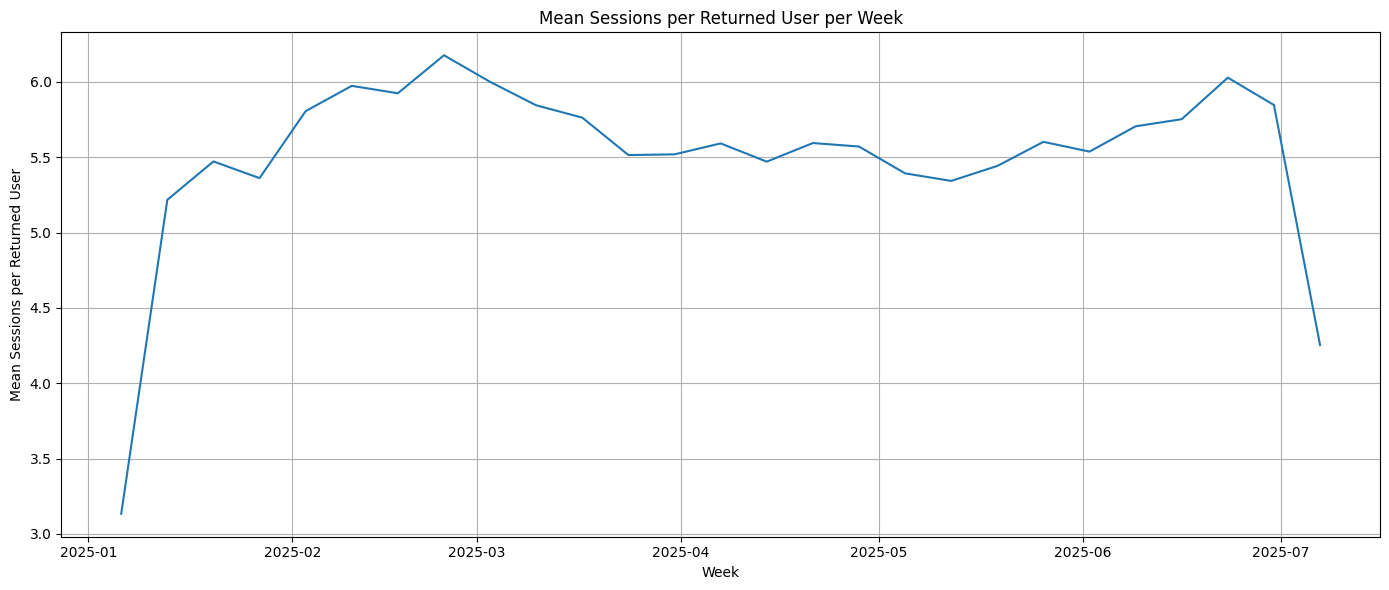

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(weekly_returned_user_sessions.index, weekly_returned_user_sessions.values)
plt.title('Mean Sessions per Returned User per Week')
plt.xlabel('Week')
plt.ylabel('Mean Sessions per Returned User')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
predicted_users['returned_sessions'] = (predicted_users['returning_users'] * avg_sessions_per_returned_user
                                         ).round().astype(int)
display(predicted_users)

,week,fact_spend,predicted_new_users,new_users_sessions,new_sessions_minutes,returning_users,returned_sessions
0,2025-07-14,1687700.0,38580,55217,205628.926082,11872,67179
1,2025-07-21,1691200.0,38718,55414,206362.557000,12677,71734
2,2025-07-28,1698200.0,38998,55815,207855.886941,12971,73398
3,2025-08-04,1732164.0,40445,57886,215568.321625,13154,74433
4,2025-08-11,1766807.0,42072,60215,224241.552131,13345,75514
5,2025-08-18,1802143.0,43895,62824,233957.506785,13547,76657
6,2025-08-25,1838186.0,45933,65741,244820.458003,13795,78061
7,2025-09-01,1874950.0,48204,68991,256923.506154,14053,79521
8,2025-09-08,1912449.0,50734,72612,270408.163802,14330,81088
9,2025-09-15,1950698.0,53549,76641,285412.219494,14623,82746


*Additionaly*, for checking some other metrics, let's also predict minutes:

In [32]:
returned_user_sessions = chat_sessions[chat_sessions['returning_user_session']].copy()
returned_user_sessions['event_time'] = pd.to_datetime(returned_user_sessions['event_time']).dt.date

avg_session_duration_returned_user = returned_user_sessions['session_duration'].mean()
print(f"Mean session duration for returned user: {avg_session_duration_returned_user:.2f} minutes")

Mean session duration for returned user: 6.90 minutes


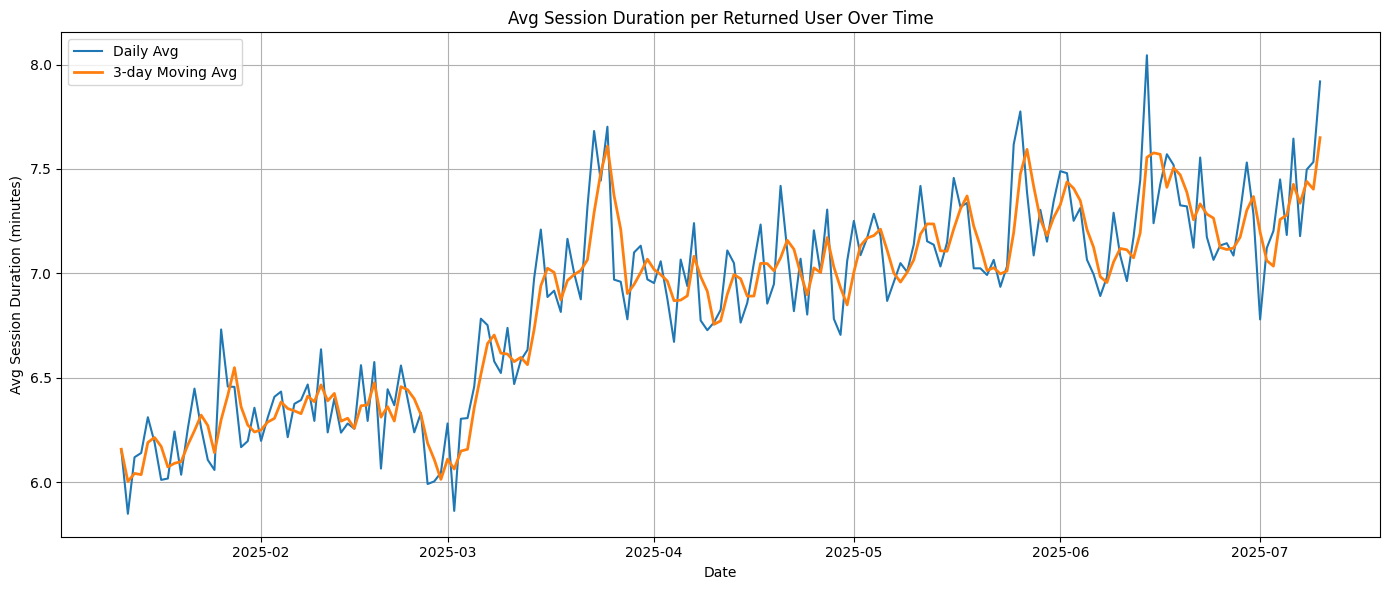

In [33]:
daily_session_duration = (
    returned_user_sessions.groupby('event_time')
    .agg(
        avg_session_duration=('session_duration', 'mean')
    )
)

daily_session_duration['moving_avg'] = (
    daily_session_duration['avg_session_duration'].rolling(window=window_size, min_periods=1).mean()
)

plt.figure(figsize=(14, 6))
plt.plot(daily_session_duration.index, daily_session_duration['avg_session_duration'], label='Daily Avg')
plt.plot(daily_session_duration.index, daily_session_duration['moving_avg'], label=f'{window_size}-day Moving Avg', linewidth=2)
plt.title('Avg Session Duration per Returned User Over Time')
plt.xlabel('Date')
plt.ylabel('Avg Session Duration (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
daily_session_duration = (
    returned_user_sessions.groupby('event_time')
    .agg(avg_session_duration=('session_duration', 'mean'))
    .reset_index()
)
daily_session_duration['date_ordinal'] = daily_session_duration['event_time'].apply(lambda d: d.toordinal())

duration_model = smf.ols('avg_session_duration ~ date_ordinal', data=daily_session_duration).fit()

print(duration_model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_session_duration   R-squared:                       0.684
Model:                              OLS   Adj. R-squared:                  0.682
Method:                   Least Squares   F-statistic:                     387.7
Date:                  Sat, 26 Jul 2025   Prob (F-statistic):           1.16e-46
Time:                          16:18:27   Log-Likelihood:                -14.639
No. Observations:                   181   AIC:                             33.28
Df Residuals:                       179   BIC:                             39.68
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -5456.5579    2

In [35]:
future_dates = predicted_new_users['week'].dt.date
future_ordinals = [d.toordinal() for d in future_dates]
future_df = pd.DataFrame({'date_ordinal': future_ordinals})

predicted_avg_session_duration = duration_model.predict(future_df)

predicted_users['returned_sessions_minutes'] = pd.Series(predicted_avg_session_duration.values) * predicted_users['returned_sessions']
display(predicted_users)

,week,fact_spend,predicted_new_users,new_users_sessions,new_sessions_minutes,returning_users,returned_sessions,returned_sessions_minutes
0,2025-07-14,1687700.0,38580,55217,205628.926082,11872,67179,508112.997410
1,2025-07-21,1691200.0,38718,55414,206362.557000,12677,71734,546275.592656
2,2025-07-28,1698200.0,38998,55815,207855.886941,12971,73398,562744.055442
3,2025-08-04,1732164.0,40445,57886,215568.321625,13154,74433,574529.571055
4,2025-08-11,1766807.0,42072,60215,224241.552131,13345,75514,586779.602055
5,2025-08-18,1802143.0,43895,62824,233957.506785,13547,76657,599626.441893
6,2025-08-25,1838186.0,45933,65741,244820.458003,13795,78061,614646.623164
7,2025-09-01,1874950.0,48204,68991,256923.506154,14053,79521,630255.888648
8,2025-09-08,1912449.0,50734,72612,270408.163802,14330,81088,646869.774747
9,2025-09-15,1950698.0,53549,76641,285412.219494,14623,82746,664376.419922


In [36]:
predicted_users['total_minutes'] = (
    predicted_users['new_sessions_minutes'] + predicted_users['returned_sessions_minutes']
)

predicted_users['total_sessions'] = (
    predicted_users['new_sessions_minutes'] + predicted_users['returned_sessions_minutes']
)

predicted_users['total_users'] = (
    predicted_users['predicted_new_users'] + predicted_users['returning_users']
)

display(predicted_users)

,week,fact_spend,predicted_new_users,new_users_sessions,new_sessions_minutes,returning_users,returned_sessions,returned_sessions_minutes,total_minutes,total_sessions,total_users
0,2025-07-14,1687700.0,38580,55217,205628.926082,11872,67179,508112.997410,713741.923491,713741.923491,50452
1,2025-07-21,1691200.0,38718,55414,206362.557000,12677,71734,546275.592656,752638.149656,752638.149656,51395
2,2025-07-28,1698200.0,38998,55815,207855.886941,12971,73398,562744.055442,770599.942383,770599.942383,51969
3,2025-08-04,1732164.0,40445,57886,215568.321625,13154,74433,574529.571055,790097.892679,790097.892679,53599
4,2025-08-11,1766807.0,42072,60215,224241.552131,13345,75514,586779.602055,811021.154186,811021.154186,55417
5,2025-08-18,1802143.0,43895,62824,233957.506785,13547,76657,599626.441893,833583.948678,833583.948678,57442
6,2025-08-25,1838186.0,45933,65741,244820.458003,13795,78061,614646.623164,859467.081166,859467.081166,59728
7,2025-09-01,1874950.0,48204,68991,256923.506154,14053,79521,630255.888648,887179.394802,887179.394802,62257
8,2025-09-08,1912449.0,50734,72612,270408.163802,14330,81088,646869.774747,917277.938548,917277.938548,65064
9,2025-09-15,1950698.0,53549,76641,285412.219494,14623,82746,664376.419922,949788.639416,949788.639416,68172


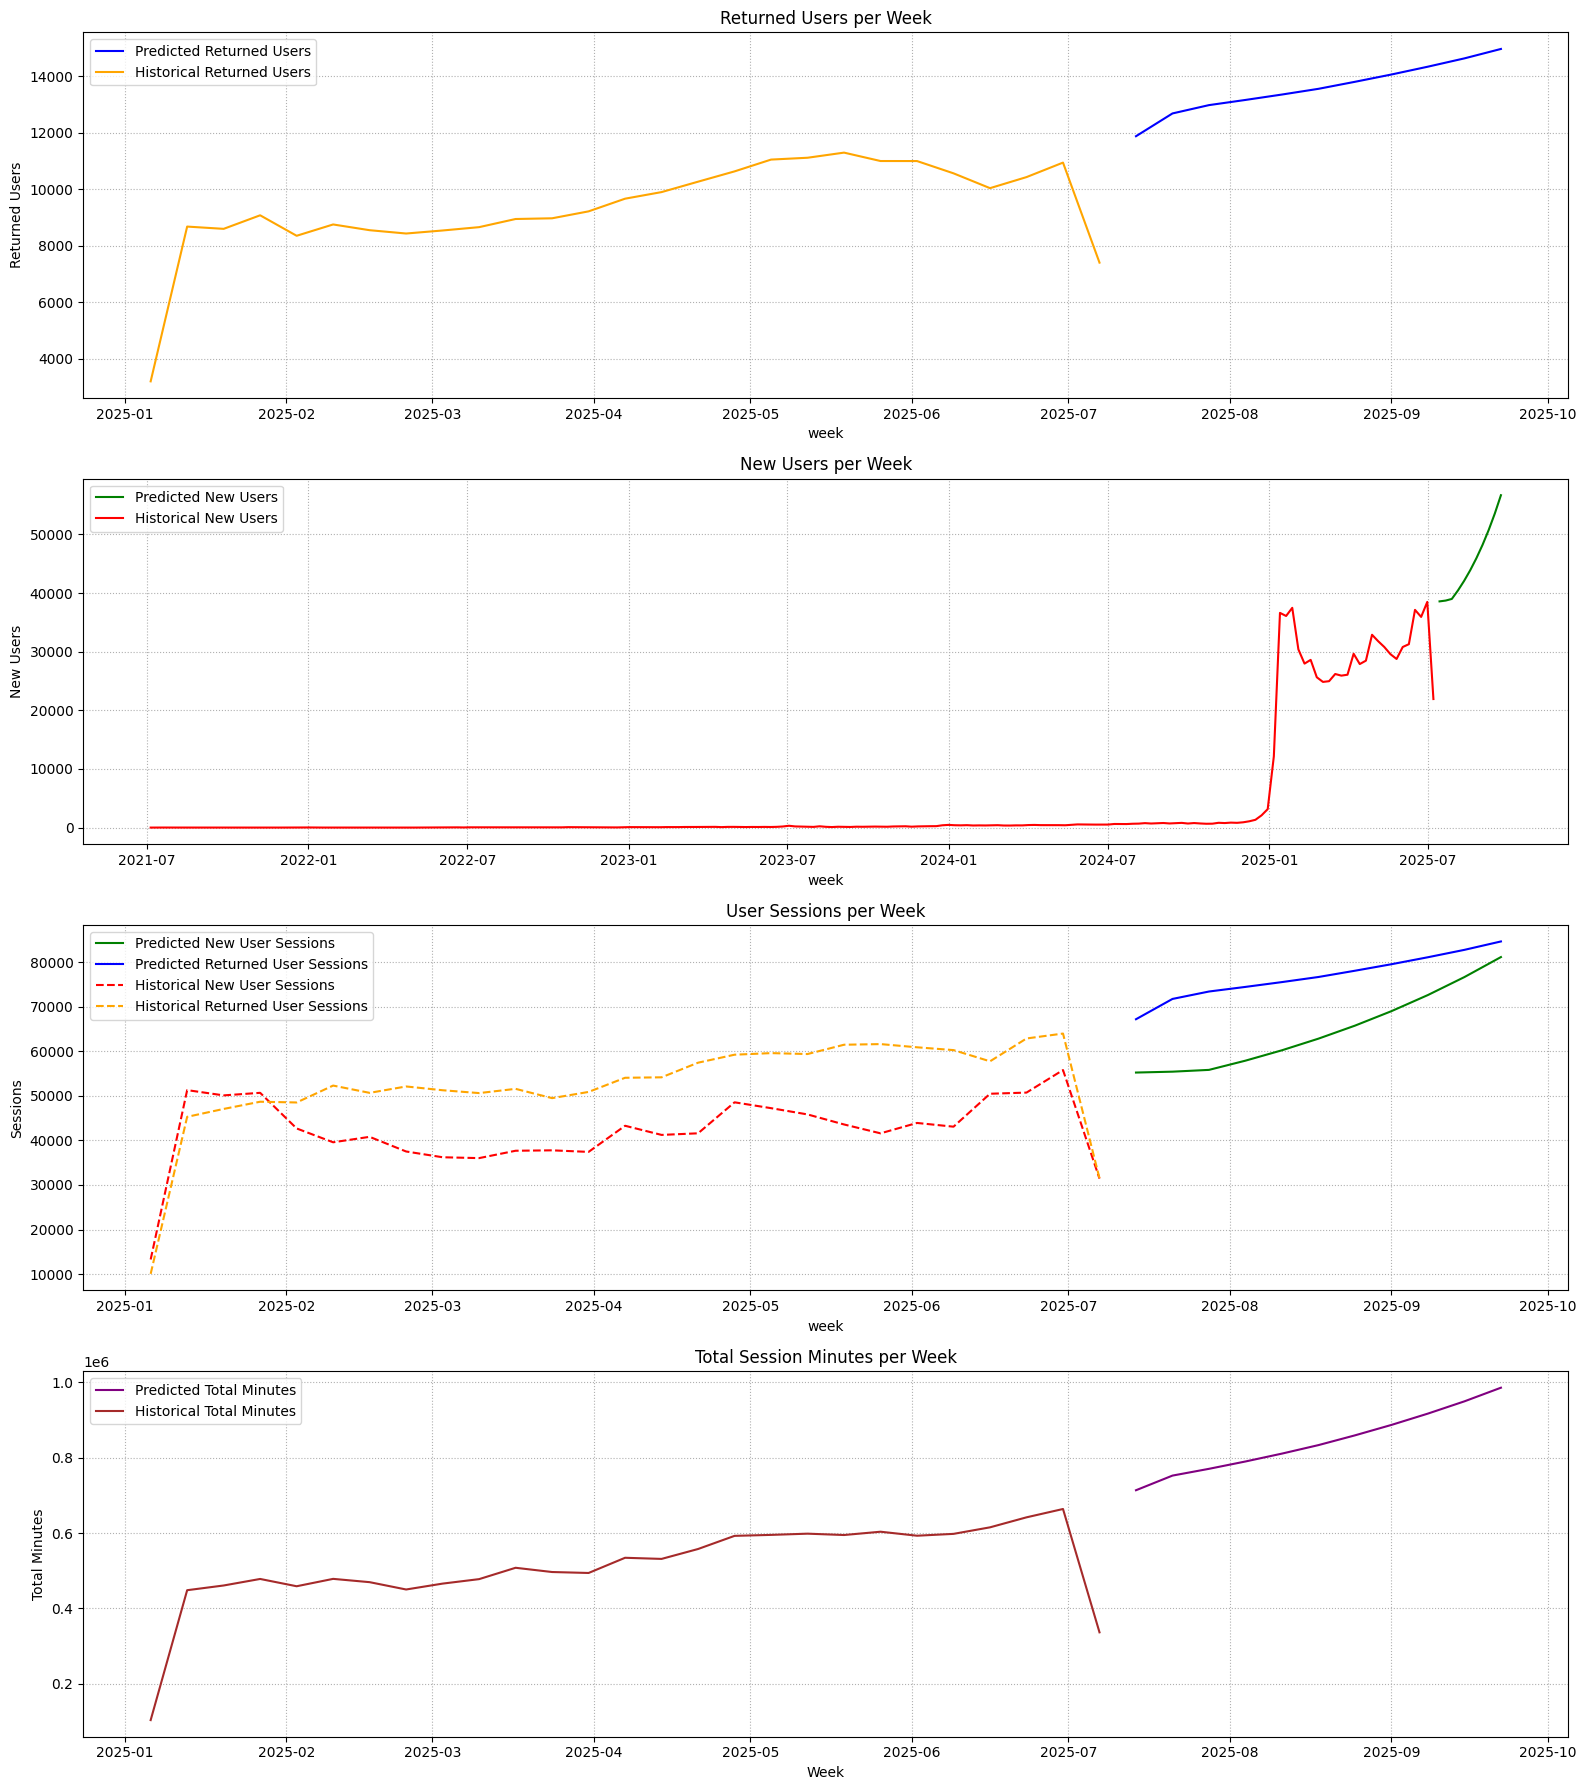

In [37]:
fig, axs = plt.subplots(4, 1, figsize=(16, 18))

# 1. Returned Users
sns.lineplot(ax=axs[0], data=predicted_users, x='week', y='returning_users', label='Predicted Returned Users', color='blue')
historical_returned_users = (
    chat_sessions[chat_sessions['returning_user_session']]
    .groupby(chat_sessions['event_time'].dt.to_period('W').dt.start_time)['user_id']
    .nunique()
    .reset_index(name='returning_users')
)
sns.lineplot(ax=axs[0], data=historical_returned_users, x='event_time', y='returning_users', label='Historical Returned Users', color='orange')
axs[0].set_ylabel('Returned Users')
axs[0].set_title('Returned Users per Week')
axs[0].legend()
axs[0].grid(True, linestyle=':')

# 2. New Users
sns.lineplot(ax=axs[1], data=predicted_users, x='week', y='predicted_new_users', label='Predicted New Users', color='green')
historical_new_users = (
    chat_sessions.drop_duplicates('user_id')
    .groupby(chat_sessions['user_first_chat'].dt.to_period('W').dt.start_time)['user_id']
    .count()
    .reset_index(name='new_users')
)
sns.lineplot(ax=axs[1], data=historical_new_users, x='user_first_chat', y='new_users', label='Historical New Users', color='red')
axs[1].set_ylabel('New Users')
axs[1].set_title('New Users per Week')
axs[1].legend()
axs[1].grid(True, linestyle=':')

# 3. Sessions (new + returned)
sns.lineplot(ax=axs[2], data=predicted_users, x='week', y='new_users_sessions', label='Predicted New User Sessions', color='green')
sns.lineplot(ax=axs[2], data=predicted_users, x='week', y='returned_sessions', label='Predicted Returned User Sessions', color='blue')
historical_sessions = (
    chat_sessions.groupby(chat_sessions['event_time'].dt.to_period('W').dt.start_time)
    .agg(new_user_sessions=('new_user_session', 'sum'), returned_sessions=('returning_user_session', 'sum'))
    .reset_index()
)
sns.lineplot(ax=axs[2], data=historical_sessions, x='event_time', y='new_user_sessions', label='Historical New User Sessions', color='red', linestyle='--')
sns.lineplot(ax=axs[2], data=historical_sessions, x='event_time', y='returned_sessions', label='Historical Returned User Sessions', color='orange', linestyle='--')
axs[2].set_ylabel('Sessions')
axs[2].set_title('User Sessions per Week')
axs[2].legend()
axs[2].grid(True, linestyle=':')

# 4. Total Minutes
sns.lineplot(ax=axs[3], data=predicted_users, x='week', y='total_minutes', label='Predicted Total Minutes', color='purple')
historical_total_minutes = (
    chat_sessions.groupby(chat_sessions['event_time'].dt.to_period('W').dt.start_time)['session_duration']
    .sum()
    .reset_index(name='total_minutes')
)
sns.lineplot(ax=axs[3], data=historical_total_minutes, x='event_time', y='total_minutes', label='Historical Total Minutes', color='brown')
axs[3].set_ylabel('Total Minutes')
axs[3].set_title('Total Session Minutes per Week')
axs[3].legend()
axs[3].grid(True, linestyle=':')

plt.xlabel('Week')
plt.tight_layout()
plt.show()

## Distributing weekly data to hourly

In [38]:
hourly_df_temp = df_hourly.copy().rename(columns={'hour': 'event_time'})
hourly_df_temp['weekday'] = hourly_df_temp['event_time'].dt.weekday
hourly_df_temp['hour'] = hourly_df_temp['event_time'].dt.hour

hourly_patterns = (
    hourly_df_temp
    .groupby(['weekday', 'hour'])[['new_user_sessions', 'returning_user_sessions', 'total_session_minutes']]
    .sum()
)

hourly_share_template_temp = hourly_patterns.divide(hourly_patterns.sum())
hourly_share_template_temp = hourly_share_template_temp.reset_index()

chat_sessions_temp = chat_sessions.copy()
chat_sessions_temp['weekday'] = chat_sessions_temp['hour'].dt.weekday
chat_sessions_temp['hour_of_day'] = chat_sessions_temp['hour'].dt.hour

unique_users_by_hour = (
    chat_sessions_temp
    .groupby(['weekday', 'hour_of_day'])['user_id']
    .nunique()
    .rename('unique_users')
    .reset_index()
    .rename(columns={'hour_of_day': 'hour'})
)

total_unique_users = chat_sessions_temp['user_id'].nunique()

unique_users_by_hour['active_users_share'] = unique_users_by_hour['unique_users'] / total_unique_users
active_users_share = unique_users_by_hour[['weekday', 'hour', 'active_users_share']]

hourly_share_full = pd.merge(hourly_share_template_temp, active_users_share, on=['weekday', 'hour'], how='left')

hourly_share_full['dow_hour'] = hourly_share_full['weekday'] * 24 + hourly_share_full['hour']
hourly_share_full = hourly_share_full.set_index('dow_hour')

cols_order = [
    'weekday', 'hour',
    'new_user_sessions', 'returning_user_sessions',
    'total_session_minutes', 'active_users_share'
]
hourly_share = hourly_share_full[cols_order].rename(columns={
    'new_user_sessions': 'new_user_sessions_share',
    'returning_user_sessions': 'returning_user_sessions_share',
    'total_session_minutes': 'total_minutes_share'
})

display(hourly_share)

,weekday,hour,new_user_sessions_share,returning_user_sessions_share,total_minutes_share,active_users_share
dow_hour,,,,,,
0,0,0,0.007829,0.007288,0.007758,0.013194
1,0,1,0.007933,0.007603,0.007894,0.013342
2,0,2,0.007736,0.006882,0.007425,0.012852
3,0,3,0.007220,0.006029,0.006471,0.011877
4,0,4,0.006587,0.005107,0.005512,0.010760
...,...,...,...,...,...,...
163,6,19,0.008129,0.007208,0.007289,0.013316
164,6,20,0.008578,0.008144,0.008785,0.014096
165,6,21,0.008683,0.008473,0.009114,0.014551


In [39]:
hourly_template = hourly_share.copy()
hourly_template['hour'] = pd.to_datetime('2025-01-06')

hourly_rows = []

for _, week_row in predicted_users.iterrows():
    week_start = pd.to_datetime(week_row['week'])
    
    for _, hour_row in hourly_share.iterrows():
        weekday = int(hour_row['weekday'])
        hour_of_day = int(hour_row['hour'])

        hour_timestamp = week_start + pd.Timedelta(days=weekday, hours=hour_of_day)

        new_sessions = hour_row['new_user_sessions_share'] * week_row['new_users_sessions']
        returning_sessions = hour_row['returning_user_sessions_share'] * week_row['returned_sessions']
        total_minutes = hour_row['total_minutes_share'] * week_row['total_minutes']
        active_users = hour_row['active_users_share'] * week_row['total_users']

        hourly_rows.append({
            'hour': hour_timestamp,
            'active_users': active_users,
            'new_user_sessions': new_sessions,
            'returning_user_sessions': returning_sessions,
            'chat_sessions': new_sessions + returning_sessions,
            'total_session_minutes': total_minutes
        })

predicted_hourly_demand = pd.DataFrame(hourly_rows)
predicted_hourly_demand[['active_users', 'new_user_sessions', 'returning_user_sessions', 'chat_sessions']] = \
    predicted_hourly_demand[['active_users', 'new_user_sessions', 'returning_user_sessions', 'chat_sessions']].round(0).astype(int)
predicted_hourly_demand = predicted_hourly_demand.sort_values('hour').reset_index(drop=True)

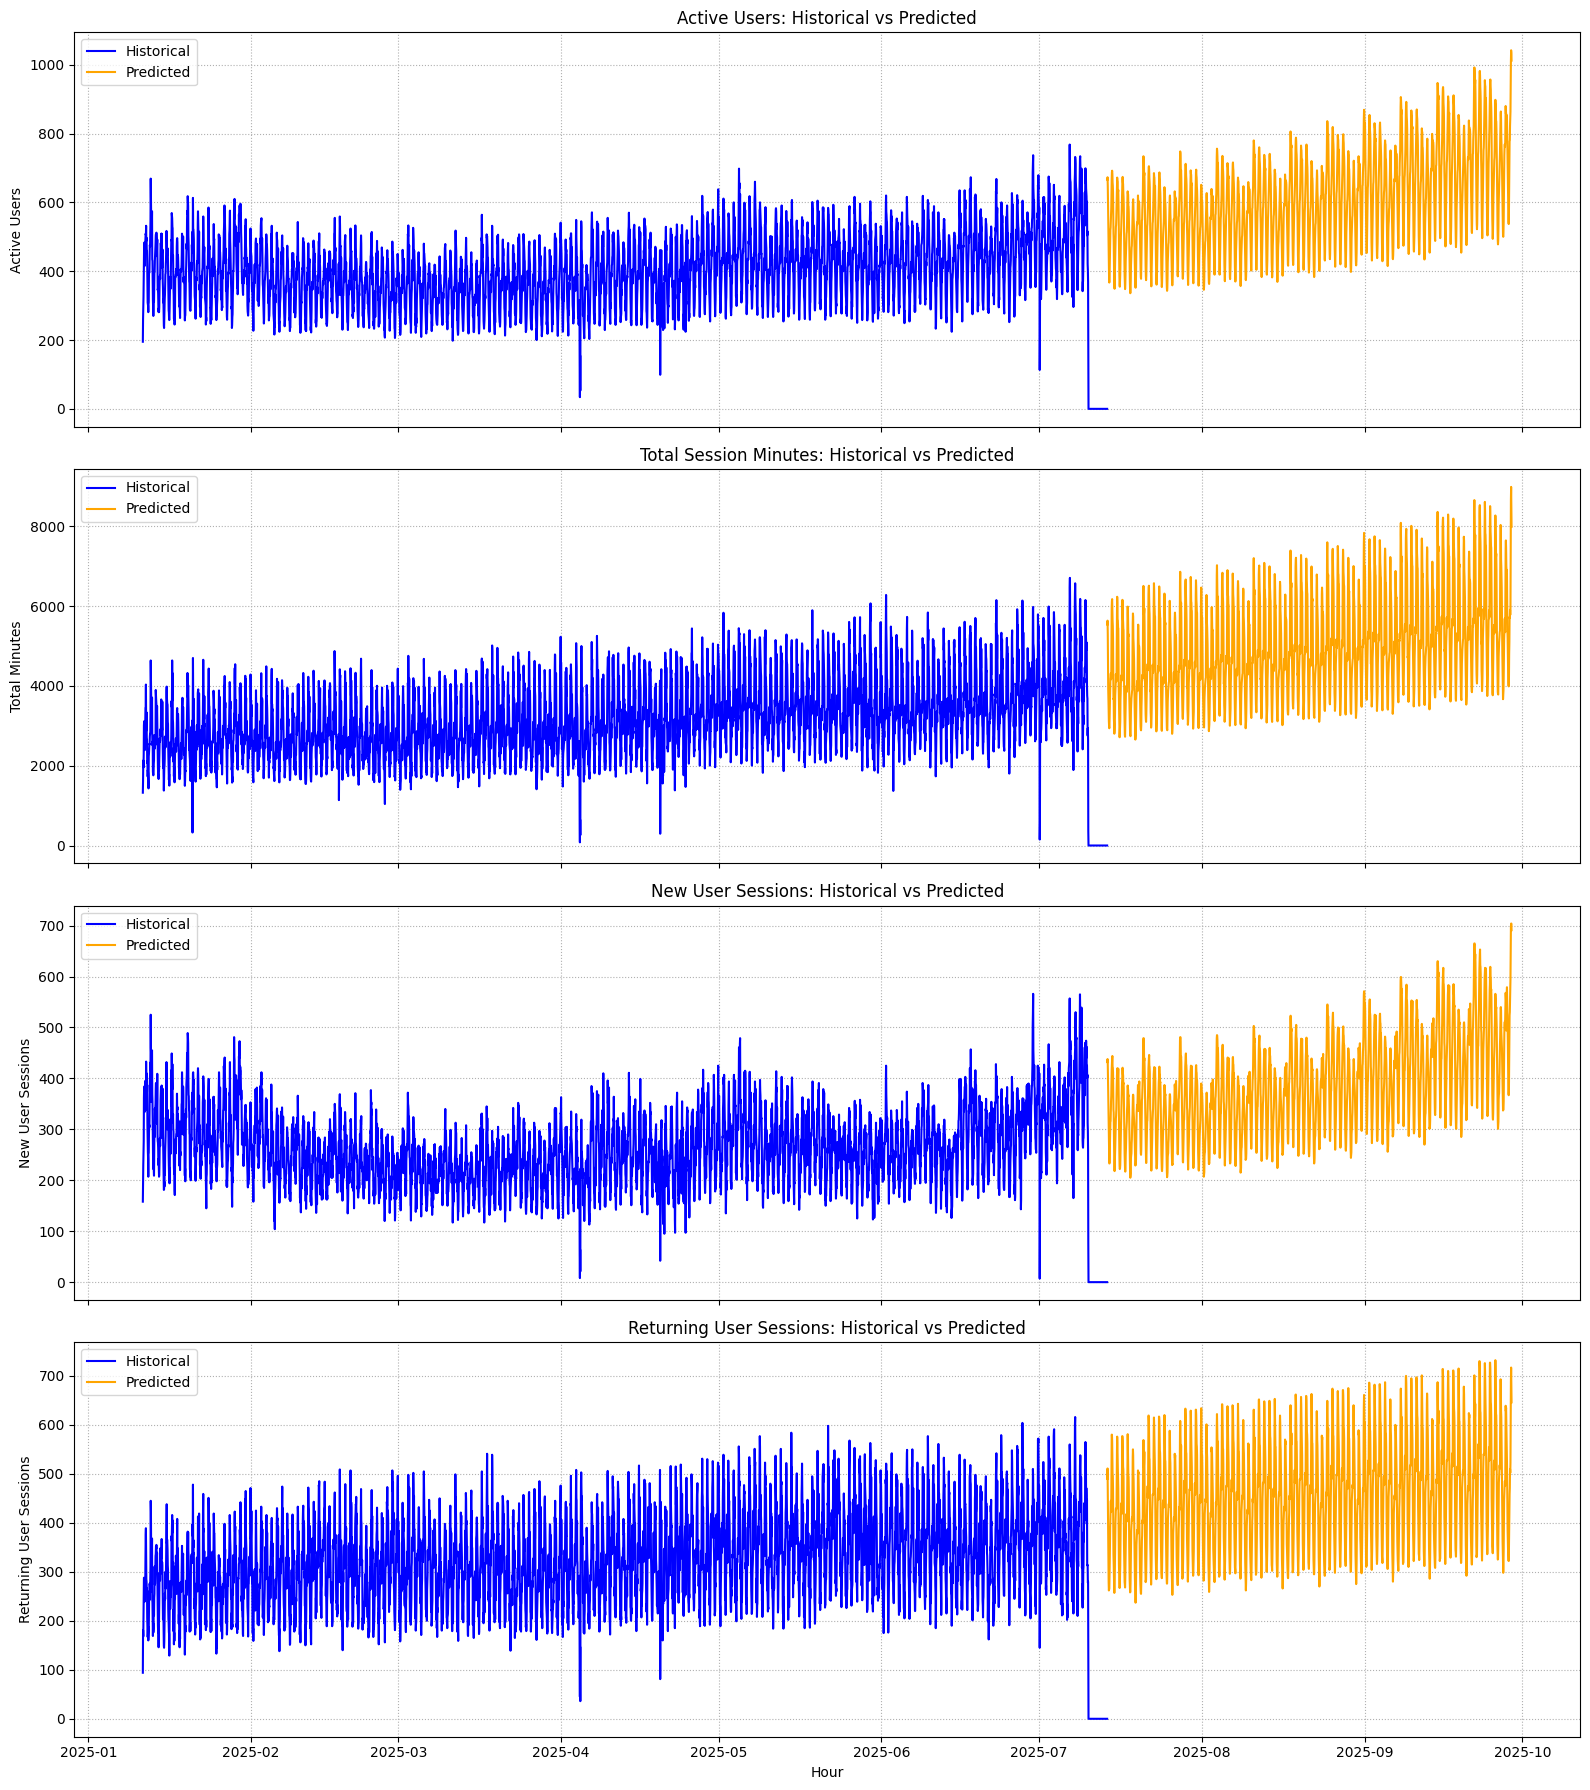

In [40]:
fig, axs = plt.subplots(4, 1, figsize=(16, 18), sharex=True)

# 1. Active Users
sns.lineplot(ax=axs[0], x=df_hourly['hour'], y=df_hourly['active_users'], label='Historical', color='blue')
sns.lineplot(ax=axs[0], x=predicted_hourly_demand['hour'], y=predicted_hourly_demand['active_users'], label='Predicted', color='orange')
axs[0].set_ylabel('Active Users')
axs[0].set_title('Active Users: Historical vs Predicted')
axs[0].legend()
axs[0].grid(True, linestyle=':')

# 2. Total Session Minutes
sns.lineplot(ax=axs[1], x=df_hourly['hour'], y=df_hourly['total_session_minutes'], label='Historical', color='blue')
sns.lineplot(ax=axs[1], x=predicted_hourly_demand['hour'], y=predicted_hourly_demand['total_session_minutes'], label='Predicted', color='orange')
axs[1].set_ylabel('Total Minutes')
axs[1].set_title('Total Session Minutes: Historical vs Predicted')
axs[1].legend()
axs[1].grid(True, linestyle=':')

# 3. New User Sessions
sns.lineplot(ax=axs[2], x=df_hourly['hour'], y=df_hourly['new_user_sessions'], label='Historical', color='blue')
sns.lineplot(ax=axs[2], x=predicted_hourly_demand['hour'], y=predicted_hourly_demand['new_user_sessions'], label='Predicted', color='orange')
axs[2].set_ylabel('New User Sessions')
axs[2].set_title('New User Sessions: Historical vs Predicted')
axs[2].legend()
axs[2].grid(True, linestyle=':')

# 4. Returning User Sessions
sns.lineplot(ax=axs[3], x=df_hourly['hour'], y=df_hourly['returning_user_sessions'], label='Historical', color='blue')
sns.lineplot(ax=axs[3], x=predicted_hourly_demand['hour'], y=predicted_hourly_demand['returning_user_sessions'], label='Predicted', color='orange')
axs[3].set_ylabel('Returning User Sessions')
axs[3].set_title('Returning User Sessions: Historical vs Predicted')
axs[3].legend()
axs[3].grid(True, linestyle=':')

plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# Estimating Supply

In [41]:
avg_expert_utilization = df_hourly['expert_utilization'].mean()
print(f"Average Expert Utilization: {avg_expert_utilization:.2%}")

Average Expert Utilization: 49.00%


In [42]:
worktime_predictive_mod = worktime_predictive.copy().rename(columns={
    'event_time': 'hour',
    'specialist_astrocrm_user_id': 'expert_id'
})

supply_by_hour = (
    worktime_predictive_mod.groupby('hour')
    .agg(
        active_experts=('expert_id', 'nunique'),
        scheduled_minutes=('scheduled_duration', 'sum')
    )
    .reset_index()
)

future_hourly_df = predicted_hourly_demand.merge(supply_by_hour, on='hour', how='left')
future_hourly_df['user_to_expert_ratio'] = future_hourly_df['active_users'] / future_hourly_df['active_experts']
future_hourly_df['supply_minutes'] = future_hourly_df['scheduled_minutes'].apply(lambda x: x * avg_expert_utilization)
future_hourly_df['coverage_rate'] = future_hourly_df['supply_minutes'] / future_hourly_df['total_session_minutes']
future_hourly_df.replace([np.inf, -np.inf], np.nan, inplace=True)
future_hourly_df.head()

,hour,active_users,new_user_sessions,returning_user_sessions,chat_sessions,total_session_minutes,active_experts,scheduled_minutes,user_to_expert_ratio,supply_minutes,coverage_rate
0,2025-07-14 00:00:00,666,432,490,922,5536.917820,174.0,10110.0,3.827586,4954.217432,0.894761
1,2025-07-14 01:00:00,673,438,511,949,5634.421453,171.0,10050.0,3.935673,4924.815548,0.874059
2,2025-07-14 02:00:00,648,427,462,889,5299.214323,177.0,10140.0,3.661017,4968.918374,0.937671
3,2025-07-14 03:00:00,599,399,405,804,4618.364198,152.0,8220.0,3.940789,4028.058090,0.872183
4,2025-07-14 04:00:00,543,364,343,707,3934.055212,147.0,8010.0,3.693878,3925.151497,0.997737


In [43]:
# Average coverage rate
avg_coverage_rate = future_hourly_df['coverage_rate'].mean()
print(f"Average Coverage Rate: {avg_coverage_rate:.2%}")

Average Coverage Rate: 57.79%


In [44]:
future_hourly_df['required_experts'] = np.ceil(future_hourly_df['active_users'] / 2).astype(int)
future_hourly_df['experts_shortage'] = future_hourly_df['required_experts'] - future_hourly_df['active_experts']

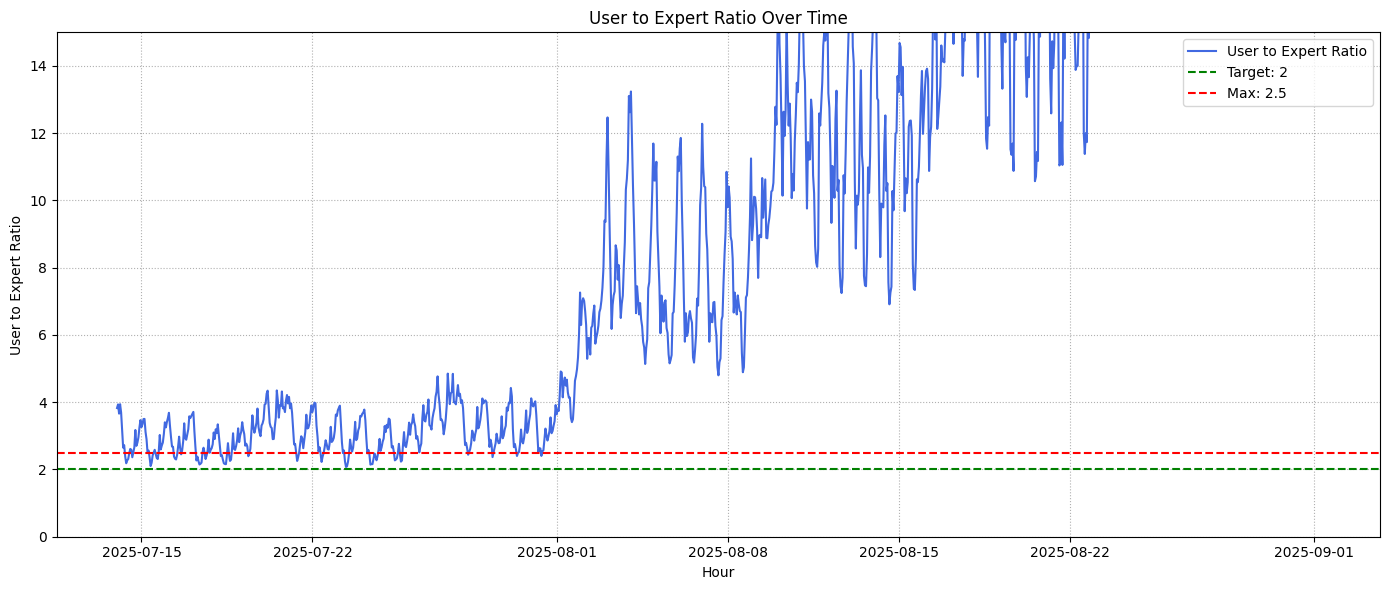

In [45]:
# Plot user to expert ratio over time
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=future_hourly_df[future_hourly_df['active_experts'].notna()],
    x='hour',
    y='user_to_expert_ratio',
    label='User to Expert Ratio',
    color='royalblue'
)
plt.axhline(2, color='green', linestyle='--', label='Target: 2')
plt.axhline(2.5, color='red', linestyle='--', label='Max: 2.5')
plt.title('User to Expert Ratio Over Time')
plt.xlabel('Hour')
plt.ylabel('User to Expert Ratio')
plt.legend()
plt.ylim(0, 15)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

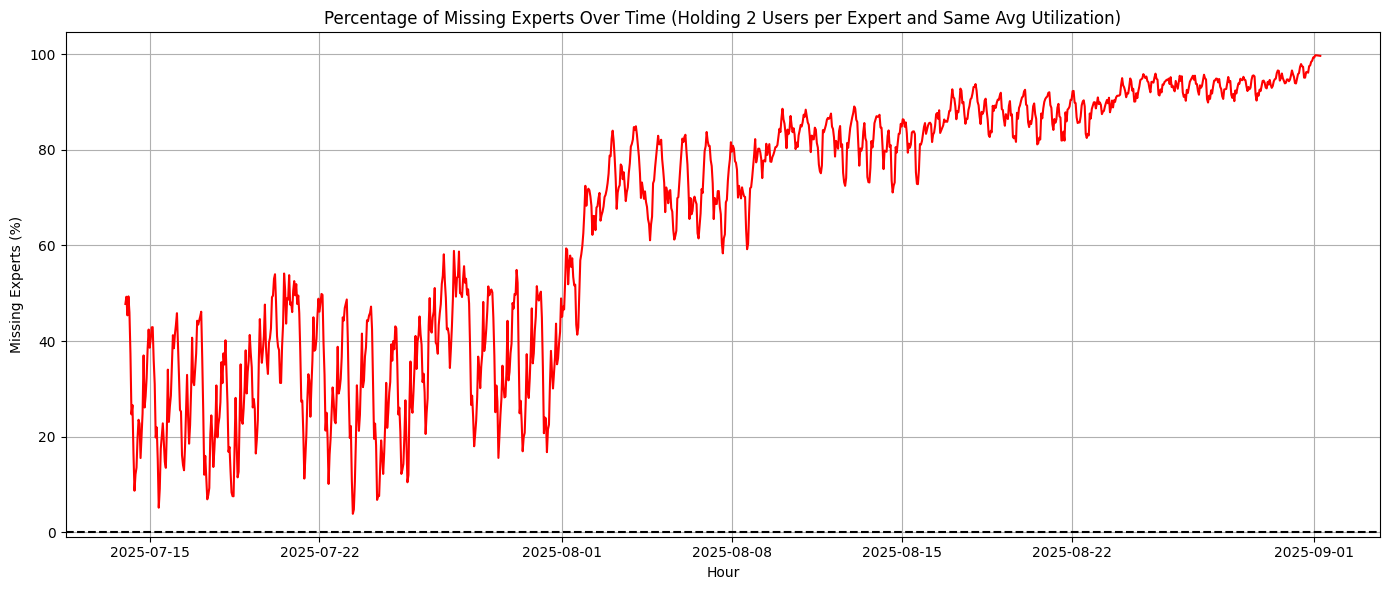

In [46]:
# Plot percentage of missing experts over time
plt.figure(figsize=(14, 6))
pctg_missing = 100 * future_hourly_df['experts_shortage'] / future_hourly_df['required_experts']
sns.lineplot(data=future_hourly_df, x='hour', y=pctg_missing, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Percentage of Missing Experts Over Time (Holding 2 Users per Expert and Same Avg Utilization)')
plt.xlabel('Hour')
plt.ylabel('Missing Experts (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Predicting **TOTAL** supply

In [54]:
total_minutes_needed = future_hourly_df['total_session_minutes'].sum()
expert_total_minutes = worktime_predictive.groupby('specialist_astrocrm_user_id')['scheduled_duration'].sum()
avg_minutes_per_expert = expert_total_minutes.mean()

required_experts_total = total_minutes_needed / (avg_minutes_per_expert * avg_expert_utilization)
required_experts_total = np.ceil(required_experts_total)
print(f"Minimum number of experts required on staff: {required_experts_total:.0f}")
print('Assumptions:')
print('- Average expert utilization remains on the same level of {:.2%}.'.format(avg_expert_utilization))
print(f'- Time frame is from {data_threshold.date()} to {future_hourly_df["hour"].max().date()}.')

Minimum number of experts required on staff: 3015
Assumptions:
- Average expert utilization remains on the same level of 49.00%.
- Time frame is from 2025-07-14 to 2025-09-28.


# Hand Input Supply Estimation

*Sample input*:

2025-07-14

1687700.00

2025-07-14

In [946]:
def validate_week_format(week):
    try:
        pd.to_datetime(week)
        return True
    except ValueError:
        return False

In [947]:
def validate_day_format(day):
    try:
        pd.to_datetime(day)
        return True
    except ValueError:
        return False

**Marketing Data Input:**

In [958]:
week = input("Enter the week (YYYY-MM-DD) to analyze: ")

week_start = pd.to_datetime(week) if validate_week_format(week) else None
print("Invalid week format. Please enter a valid date in YYYY-MM-DD format.") if week_start is None else f"Week start date: {week_start}"

'Week start date: 2025-07-14 00:00:00'

In [949]:
marketing_spend = input("Enter the marketing spend for the week: ")

try:
    marketing_spend = float(marketing_spend)
except ValueError:
    marketing_spend = None
    print("Invalid spend format. Please enter a valid number.")
if marketing_spend is not None:
    print(f"Marketing spend for the week: ${marketing_spend:.2f}")

Marketing spend for the week: $1687700.00


**Day Input:**

In [950]:
day = input("Enter the day (YYYY-MM-DD) to analyze: ")
day_date = pd.to_datetime(day) if validate_day_format(day) else None
print("Invalid day format. Please enter a valid date in YYYY-MM-DD format.") if day_date is None else f"Day date: {day_date}"

if week_start is not None and day_date is not None:
    if not (week_start <= day_date < week_start + pd.Timedelta(days=7)):
        print(f"The day {day_date} is not within the week starting {week_start}.")

In [ ]:
marketing_data_hi = pd.DataFrame({
    'week': [week_start],
    'fact_spend': [marketing_spend]
})

2025-07-14 00:00:00 1687700.0 2025-07-14 00:00:00


,week,fact_spend
0,2025-07-14,1687700.0


## **Result:**

In [964]:
future_hi = marketing_data_hi.copy()
future_hi = future_hi.rename(columns={'expected_spend': 'fact_spend'})
future_hi['fact_spend_log'] = np.log1p(future_hi['fact_spend'])
future_hi['fact_spend_log_sq'] = future_hi['fact_spend_log'] ** 2

pred_results = user_model.get_prediction(future_hi)
pred_summary = pred_results.summary_frame(alpha=0.05)  # 95% CI

future_hi.reset_index(drop=True, inplace=True)

future_hi['new_users_log_pred'] = pred_summary['mean']
future_hi['predicted_new_users'] = np.expm1(pred_summary['mean'])
future_hi['predicted_new_users_lower'] = np.expm1(pred_summary['mean_ci_lower'])
future_hi['predicted_new_users_upper'] = np.expm1(pred_summary['mean_ci_upper'])

predicted_new_users_hi = future_hi[['week', 'fact_spend', 'predicted_new_users_upper']].copy()
predicted_new_users_hi['predicted_new_users'] = predicted_new_users_hi['predicted_new_users_upper'].round().astype(int)
predicted_new_users_hi.drop(columns='predicted_new_users_upper', inplace=True)

predicted_new_users_hi['new_users_sessions'] = (predicted_new_users_hi['predicted_new_users'] * avg_sessions_per_new_user
                                             ).round().astype(int)

predicted_new_users_hi['new_sessions_minutes'] = predicted_new_users_hi['new_users_sessions'] * avg_session_duration_new_user

predicted_users_hi = compute_returning_users(new_users_weekly, predicted_new_users_hi, avg_retention_curve)
predicted_users_hi['returning_users'] = predicted_users_hi['returning_users'].astype(int) + 7000

predicted_users_hi['returned_sessions'] = (predicted_users_hi['returning_users'] * avg_sessions_per_returned_user
                                         ).round().astype(int)

future_dates = predicted_new_users_hi['week'].dt.date
future_ordinals = [d.toordinal() for d in future_dates]
future_df = pd.DataFrame({'date_ordinal': future_ordinals})

predicted_avg_session_duration_hi = duration_model.predict(future_df)

predicted_users_hi['returned_sessions_minutes'] = pd.Series(predicted_avg_session_duration_hi.values) * predicted_users_hi['returned_sessions']

predicted_users_hi['total_minutes'] = (
    predicted_users_hi['new_sessions_minutes'] + predicted_users_hi['returned_sessions_minutes']
)
predicted_users_hi['total_sessions'] = (
    predicted_users_hi['new_sessions_minutes'] + predicted_users_hi['returned_sessions_minutes']
)
predicted_users_hi['total_users'] = (
    predicted_users_hi['predicted_new_users'] + predicted_users_hi['returning_users']
)

hourly_template = hourly_share.copy()
hourly_template['hour'] = pd.to_datetime('2025-01-06')

hourly_rows = []

for _, week_row in predicted_users_hi.iterrows():
    week_start = pd.to_datetime(week_row['week'])
    
    for _, hour_row in hourly_share.iterrows():
        weekday = int(hour_row['weekday'])
        hour_of_day = int(hour_row['hour'])

        hour_timestamp = week_start + pd.Timedelta(days=weekday, hours=hour_of_day)

        new_sessions = hour_row['new_user_sessions_share'] * week_row['new_users_sessions']
        returning_sessions = hour_row['returning_user_sessions_share'] * week_row['returned_sessions']
        total_minutes = hour_row['total_minutes_share'] * week_row['total_minutes']
        active_users = hour_row['active_users_share'] * week_row['total_users']

        hourly_rows.append({
            'hour': hour_timestamp,
            'active_users': active_users,
            'new_user_sessions': new_sessions,
            'returning_user_sessions': returning_sessions,
            'chat_sessions': new_sessions + returning_sessions,
            'total_session_minutes': total_minutes
        })

predicted_hourly_demand_hi = pd.DataFrame(hourly_rows)
predicted_hourly_demand_hi[['active_users', 'new_user_sessions', 'returning_user_sessions', 'chat_sessions']] = \
    predicted_hourly_demand_hi[['active_users', 'new_user_sessions', 'returning_user_sessions', 'chat_sessions']].round(0).astype(int)
predicted_hourly_demand_hi = predicted_hourly_demand_hi.sort_values('hour').reset_index(drop=True)

predicted_hourly_demand_hi['required_experts'] = np.ceil(predicted_hourly_demand_hi['active_users'] / 2).astype(int)

display(predicted_hourly_demand_hi[predicted_hourly_demand_hi['hour'].dt.day == day_date.day])

,hour,active_users,new_user_sessions,returning_user_sessions,chat_sessions,total_session_minutes,required_experts
0,2025-07-14 00:00:00,666,432,490,922,5536.917820,333
1,2025-07-14 01:00:00,673,438,511,949,5634.421453,337
2,2025-07-14 02:00:00,648,427,462,889,5299.214323,324
3,2025-07-14 03:00:00,599,399,405,804,4618.364198,300
4,2025-07-14 04:00:00,543,364,343,707,3934.055212,272
5,2025-07-14 05:00:00,498,343,312,655,3723.847343,249
6,2025-07-14 06:00:00,445,303,279,582,3406.924238,223
7,2025-07-14 07:00:00,406,275,262,537,3120.465058,203
8,2025-07-14 08:00:00,378,249,265,515,2992.240620,189
9,2025-07-14 09:00:00,367,233,265,498,2938.290631,184


In [974]:
hour = input("Enter the hour (HH:MM) to analyze: ")
try:
    pd.to_datetime(hour, format='%H:%M').time()
except ValueError:
    hour = None
hour_time = pd.to_datetime(hour, format='%H:%M').time() if hour else None
if hour_time is not None:
    hour_time = pd.Timestamp.combine(pd.Timestamp(
        '2025-01-06'), hour_time).round('H').time()
    req_exp = predicted_hourly_demand_hi[(predicted_hourly_demand_hi['hour'].dt.time == hour_time) & (
        predicted_hourly_demand_hi['hour'].dt.day == day_date.day)]['required_experts'].values[0]
    print(f"Required experts for {hour_time} on {day_date.date()}: {req_exp}")
else:
    print("Invalid hour format. Please enter a valid time in HH:MM format.")

Required experts for 10:00:00 on 2025-07-14: 190
